In [19]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pandas as pd
import csv
import re
from numpy import histogram

from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot

from keras import backend as K

In [ ]:
def return_top_diag(diags, top_diagnoses):  
    top_diagnoses= list(top_diagnoses.head(100).index)
    return [x if x in top_diagnoses else 'other' for x in diags]

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py with some
    with several modifications for present implementation
    """
    
    #remove whitespace
    string = string.strip()
    
    #Remove most non-alphanumeric characters, and lowercase everything
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = string.lower()
    
    #Remove database links in the text which are of the form [...] or *....*
    string = re.sub(r"\b\[\]\b", " ", string)
    string = re.sub(r"\**\*", " ", string)
    string = re.sub(r"\(*\)", " ", string)
    
    #Remove weird 1 character tokens with the exception of a and i
    string = re.sub(r'\b[b-z^i]{1}\b', " ", string)
    
    #tokenize contractions and replaces numbers with _num
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\(", " ", string)
    string = re.sub(r"\)", " ", string)
    string = re.sub(r"[0-9]", "", string)
    
    
    #Only return up to the diagnosis section of the note
    keyword = 'diagnosis'
    before_keyword, keyword, after_keyword = string.partition(keyword)
    string = before_keyword
    
    keyword = 'diagnoses'
    before_keyword, keyword, after_keyword = string.partition(keyword)
    string = before_keyword
    
    #Use special word to pad up to 1000 words and trim after 1000 words
    if len(string.split()) < 600:
        diff = 1000-len(string.split())
        string = string + ' _pad'*(diff)
    else: 
        string = " ".join(string.split()[0:600])
        
    return string

def load_data_and_labels(text_file, diagnosis_file):
    #Read in the NOTEEVENTS file chunk at a time so it doesn't have to be stored in memory
    reader = pd.read_table(text_file, engine ='python', chunksize=1000,sep=",", error_bad_lines=False)
    

    #Only interested in discharge summary notes
    df = pd.concat([chunk[chunk['CATEGORY']=='Discharge summary'] for chunk in reader])
    print('done reading')
    
    #Remove other columns and standardize admission ID as int
    df = df[['HADM_ID', 'TEXT']]
    df['HADM_ID'] = df['HADM_ID'].astype(int)
    
    #Read in diagnoses and only keep two columns of interest
    diagnoses = pd.read_csv(diagnosis_file)
    diagnoses = diagnoses[['HADM_ID', 'ICD9_CODE']]

    #make sure we don't treat labels as integers
    diagnoses['ICD9_CODE'] = diagnoses['ICD9_CODE'].astype(str)
    
    texts = []
    labels = []
    #Just in case there are admissions missing diagnoses
    unlabeled = []
    top_diagnoses = diagnoses.groupby('ICD9_CODE').count().sort_values(by=['HADM_ID'], ascending=False)

    for i in df.index:
        hadm_id = df['HADM_ID'][i]
        diags = list(diagnoses['ICD9_CODE'][diagnoses['HADM_ID'] == hadm_id])
        if diags == []:
            unlabeled.append(i)
            pass
        labels.append(return_top_diag(diags, top_diagnoses))
        texts.append(clean_str(df['TEXT'][i]))
    return texts, labels

In [17]:
diagnoses = pd.read_csv("DIAGNOSES_ICD.csv")

In [32]:
diagnoses.groupby('ICD9_CODE').count().sort_values(by=['ROW_ID'], ascending=False)['ROW_ID'].head(100)

ICD9_CODE
4019     20703
4280     13111
42731    12891
41401    12429
5849      9119
25000     9058
2724      8690
51881     7497
5990      6555
53081     6326
2720      5930
V053      5779
V290      5519
2859      5406
2449      4917
486       4839
2851      4552
2762      4528
496       4431
99592     3912
V5861     3806
0389      3725
5070      3680
V3000     3566
5859      3435
311       3431
40390     3421
3051      3358
412       3278
2875      3065
         ...  
60000     1490
7907      1478
2930      1445
00845     1444
2768      1425
4439      1401
5789      1397
V4501     1390
27651     1385
28521     1384
27652     1374
431       1367
4275      1361
E8788     1350
2765      1348
V4986     1327
769       1314
79902     1298
70703     1289
5715      1287
V103      1277
99591     1272
2639      1259
42832     1240
99812     1224
42833     1220
07054     1218
42732     1217
E8782     1211
V1046     1207
Name: ROW_ID, Length: 100, dtype: int64

In [ ]:
x_text, y_full = load_data_and_labels('NOTEEVENTS.csv', "DIAGNOSES_ICD.csv")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_full)

done reading


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_text)
sequences = tokenizer.texts_to_sequences(x_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)
labels = y

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 84489 unique tokens.
Shape of data tensor: (59652, 1000)
Shape of label tensor: (59652, 101)


In [5]:
 # Build vocabulary
# max_document_length = max([len(x.split(" ")) for x in x_text])
# vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
# x = np.array(list(vocab_processor.fit_transform(x_text)))
vocab = sorted(set(" ".join(x_text).split()))
vocab_index = dict(zip(range(len(vocab)),vocab))

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

print("Vocabulary Size: {:d}".format(len(vocab)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 84521
Train/Dev split: 53686/5966


In [6]:
embeddings_index = {}

In [14]:
##Portions of the model building code in the following sections taken from
##https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/ 
##with some modifications

embedding_matrix = np.random.random((len(vocab) + 1, EMBEDDING_DIM))
for word, i in vocab_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
embedding_layer = Embedding(len(vocab_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=True)
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


In [11]:
for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)

/home/asered/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
  
/home/asered/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
  
/home/asered/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
  


In [12]:
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(101, activation='sigmoid')(l_dense)


In [13]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy', 'categorical_accuracy'])

print("model fitting - more complex convolutional neural network")
model.summary()
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=1, batch_size=100)

model fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 300)    25356600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 998, 128)     115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 997, 128)     153728      embedding_1[0][0]                
___________________________________________________

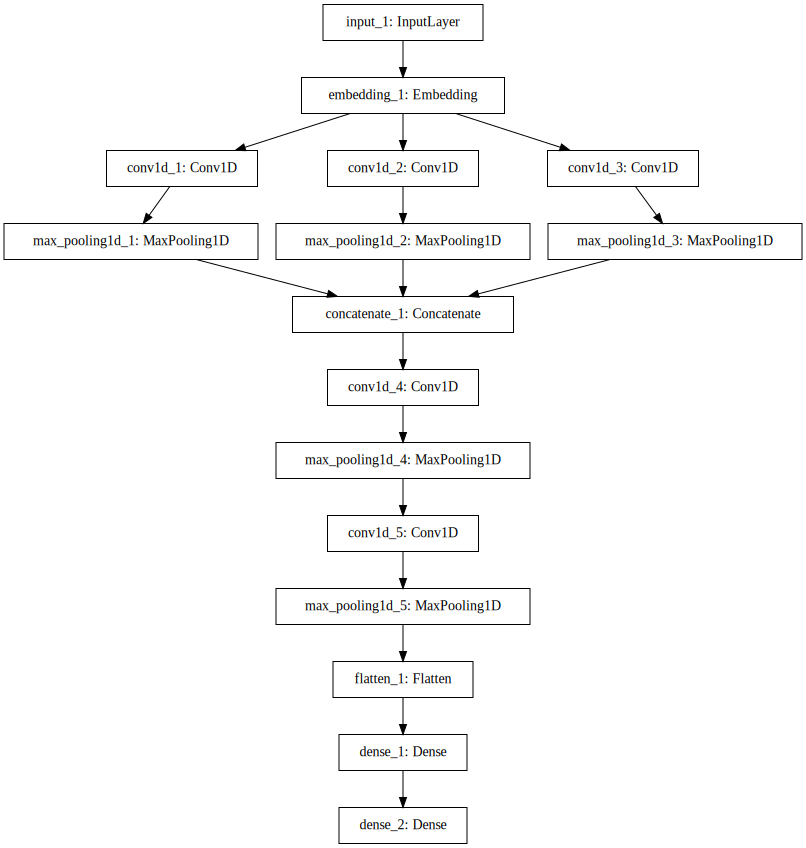

In [17]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
#plot_model(model, to_file='model.png')


In [41]:
K.clear_session()